In [1]:
import autosklearn.classification
import pandas as pd
from joblib import dump, load
import numpy as np
import glob

/opt/conda/lib/python3.7/site-packages/pyparsing.py:3174: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


In [2]:
models = []
for model_path in glob.glob("model_3cv/model_run_*"):
    models.append(load(model_path))

In [3]:
bad_models = []
for model_path in glob.glob("model_3cv/bad_auto_model_run_*"):
    bad_models.append(load(model_path))

In [4]:
numeric_conv_cols = ['age', 'age_o', 'importance_same_race', 'importance_same_religion', 'pref_o_attractive', 'pref_o_sincere',\
                    'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests', 'attractive_o', 'sinsere_o', \
                    'intelligence_o', 'funny_o', 'ambitous_o', 'shared_interests_o', 'attractive_important', 'sincere_important', \
                    'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important', \
                    'attractive', 'sincere', 'intelligence', 'funny', 'ambition', 'attractive_partner', 'sincere_partner', \
                     'intelligence_partner', 'funny_partner', 'ambition_partner', 'shared_interests_partner', 'sports', \
                     'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', \
                     'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'interests_correlate', 'expected_happy_with_sd_people', \
                    'expected_num_interested_in_me', 'expected_num_matches', 'like', 'guess_prob_liked', 'met', 'gender']

In [5]:
df = pd.read_csv("speeddating_reduced.csv")
X= df[numeric_conv_cols].fillna(-1) # required for DT
y= df['match']

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report,precision_recall_fscore_support

kf = KFold(n_splits=3, shuffle=True, random_state=42)
clfs = []
metrics = []

def get_metrics(y_true, y_pred):
    p,r,f1,s = precision_recall_fscore_support(y_true, y_pred, average=None)
    return {
        'p_pos': p[1], 'p_neg': p[0],
        'r_pos': r[1], 'r_neg': r[0],
        'acc': np.sum(r*s/np.sum(s)),
        'acc_bal': np.mean(r),
        'f1': f1[1]
    }
    

for model, name in zip(models+bad_models, ['good_'+str(i) for i in range(1,4)] + ['bad_'+str(i) for i in range(1,4)]):
    print("-"*60)
    print("Checking model", name)
    mod_metrics = []
    for idx, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        clf = DecisionTreeClassifier(random_state=21038, max_depth=5)
        clf.fit(X_train, y_pred_train)
        clfs.append(clf)
        y_gs_train = clf.predict(X_train)
        metric_dic = {}
        metric_dic['pred_sur_train'] = get_metrics(y_pred_train, y_gs_train)
        metric_dic['real_pred_train'] = get_metrics(y_train, y_pred_train)
        metric_dic['real_sur_train'] = get_metrics(y_train, y_gs_train)
        
        y_gs_test = clf.predict(X_test)
        
        metric_dic['pred_sur_test'] = get_metrics(y_pred_test, y_gs_test)
        metric_dic['real_pred_test'] = get_metrics(y_test, y_pred_test)
        metric_dic['real_sur_test'] = get_metrics(y_test, y_gs_test)
        mod_metrics.append(metric_dic)
        
    metrics.append(mod_metrics)

------------------------------------------------------------
Checking model good_1
------------------------------------------------------------
Checking model good_2
------------------------------------------------------------
Checking model good_3
------------------------------------------------------------
Checking model bad_1
------------------------------------------------------------
Checking model bad_2
------------------------------------------------------------
Checking model bad_3


In [7]:
import scipy.stats as st

def mean_confidence_interval(data, confidence=0.95):
    n = len(data)
    m, se = np.mean(data), st.sem(data)
    h = se * st.t.ppf((1 + confidence) / 2., n-1)
    return m, h

def get_stats(scenario, metric, per_model_cfg=False):
    stats = []
    for model_metrics in metrics:
        scores = np.array([x[scenario][metric] for x in model_metrics])
        stats.append((scores, mean_confidence_interval(scores)))
    
    if per_model_cfg:
        # aggregate per model cfg (i.e. bad / good)
        good_cfg = np.concatenate([s[0] for s in stats[:3]])
        bad_cfg = np.concatenate([s[0] for s in stats[3:]])
        return [(good_cfg, mean_confidence_interval(good_cfg)), (bad_cfg, mean_confidence_interval(bad_cfg))]
    return stats

In [8]:
for stat in ['p_pos', 'p_neg', 'r_pos', 'r_neg', 'acc', 'acc_bal', 'f1']:
    print(stat)
    print(get_stats('pred_sur_train', stat, per_model_cfg=True))

p_pos
[(array([0.79365079, 0.84330484, 0.87394068, 0.87620064, 0.85      ,
       0.89632107, 0.82687927, 0.82962963, 0.84375   ]), (0.848186325133068, 0.023667467587305084)), (array([0.70208333, 0.74874372, 0.72135417, 0.83823529, 0.74528302,
       0.7364532 , 0.76595745, 0.75494071, 0.76744186]), (0.7533880835872284, 0.029256578914616346))]
p_neg
[(array([0.94621696, 0.92431598, 0.92158552, 0.93610155, 0.92802617,
       0.92748987, 0.93791003, 0.93577332, 0.92784693]), (0.9316962583491311, 0.006004514309910322)), (array([0.97277179, 0.97358782, 0.9715494 , 0.97445186, 0.9697733 ,
       0.98108108, 0.97588785, 0.97580645, 0.96872091]), (0.9737367180594035, 0.00284986836375591))]
r_pos
[(array([0.8010118 , 0.72136474, 0.69386039, 0.73434705, 0.72033898,
       0.7027972 , 0.8042836 , 0.8045977 , 0.77086384]), (0.7503850345362413, 0.03468422077621729)), (array([0.70798319, 0.68505747, 0.65176471, 0.68019093, 0.66949153,
       0.75314861, 0.58252427, 0.596875  , 0.4954955 ]), (0.6469

In [9]:
for stat in ['p_pos', 'p_neg', 'r_pos', 'r_neg', 'acc', 'acc_bal', 'f1']:
    print(stat)
    print(get_stats('pred_sur_test', stat, per_model_cfg=True))

p_pos
[(array([0.76623377, 0.80698152, 0.82780083, 0.82352941, 0.82291667,
       0.8375286 , 0.78924419, 0.75898204, 0.83724832]), (0.8078294824765716, 0.022871718173263136)), (array([0.62162162, 0.71891892, 0.70744681, 0.68681319, 0.67195767,
       0.74654378, 0.70491803, 0.69026549, 0.80373832]), (0.705802647099271, 0.03868306962402445))]
p_neg
[(array([0.93339458, 0.92237641, 0.90692641, 0.91434783, 0.93687851,
       0.9104034 , 0.92446556, 0.92611765, 0.91302368]), (0.9208815573921538, 0.007987994789084867)), (array([0.98776638, 0.96165644, 0.9577573 , 0.9617005 , 0.98271889,
       0.96699029, 0.96780232, 0.96902985, 0.97690875]), (0.9702589692134228, 0.007818867008942396))]
r_pos
[(array([0.7649919 , 0.68706294, 0.64983713, 0.67330017, 0.73012939,
       0.63431542, 0.77350427, 0.76355422, 0.72318841]), (0.711098204835619, 0.04004636912841262)), (array([0.83854167, 0.57081545, 0.5473251 , 0.55555556, 0.73837209,
       0.65587045, 0.5       , 0.48447205, 0.58108108]), (0.60800

In [10]:
for stat in ['p_pos', 'p_neg', 'r_pos', 'r_neg', 'acc', 'acc_bal', 'f1']:
    print('-'*40)
    print(stat)
    print(get_stats('real_pred_test', stat, per_model_cfg=True))
    print(get_stats('real_sur_test', stat, per_model_cfg=True))

----------------------------------------
p_pos
[(array([0.44084279, 0.55594406, 0.59609121, 0.55555556, 0.49168207,
       0.64471404, 0.46581197, 0.48493976, 0.47971014]), (0.5239212869486516, 0.05200442139425091)), (array([0.61458333, 0.87124464, 0.88065844, 0.85777778, 0.68023256,
       0.90688259, 0.85465116, 0.90062112, 0.77702703]), (0.8159642932867817, 0.07988820196624842))]
[(array([0.4025974 , 0.49897331, 0.55186722, 0.44421907, 0.4625    ,
       0.53775744, 0.38662791, 0.41317365, 0.47651007]), (0.4638028954736386, 0.04488131597278329)), (array([0.58301158, 0.64864865, 0.69680851, 0.59340659, 0.60846561,
       0.71428571, 0.64754098, 0.66371681, 0.69158879]), (0.6497192490298915, 0.036119218484341145))]
----------------------------------------
p_neg
[(array([0.92003676, 0.93471409, 0.95179063, 0.94931507, 0.9125222 ,
       0.95530474, 0.94308943, 0.93377172, 0.93339676]), (0.9371046024606549, 0.01106593140737518)), (array([0.87389466, 0.8984375 , 0.89917615, 0.90147975, 0

In [11]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

%matplotlib inline

Like avg 0.396352880463041
Funny_partner avg 0.044806763789568445
Expected_num_matches avg 0.003928844952276276
Funny_o std 0.15224730099207415


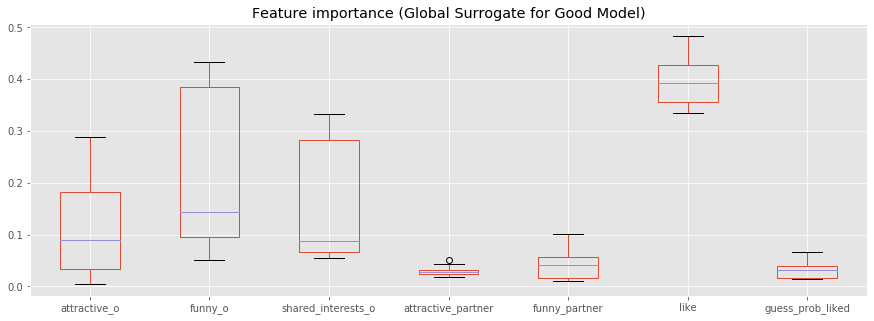

In [12]:
df_fi = pd.DataFrame(np.stack([clf.feature_importances_ for clf in clfs[:9]]))
df_fi.columns = numeric_conv_cols
crit = df_fi.max()>0.05
df_fi[crit.index[crit]].boxplot(figsize=(15,5))
plt.title('Feature importance (Global Surrogate for Good Model)')
print('Like avg', df_fi.like.mean())
print('Funny_partner avg', df_fi.funny_partner.mean())
print('Expected_num_matches avg', df_fi.expected_num_matches.mean())
print('Funny_o std', df_fi.funny_o.std())

Like avg 0.23786016061897453
Funny_partner avg 0.0007750840672041522
Expected_num_matches avg 0.15939634375970513
Funny_o std 0.05361683230599633


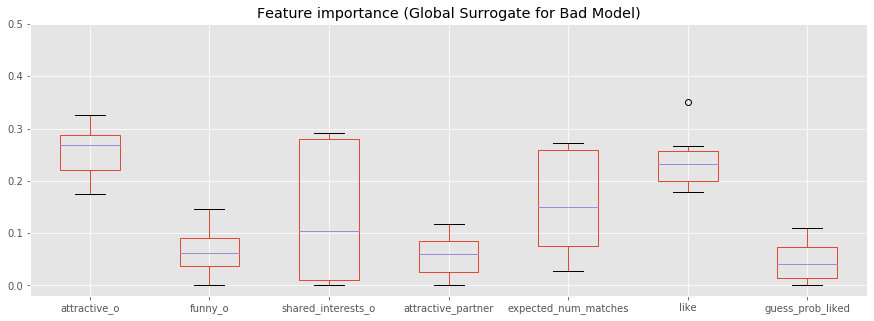

In [13]:
df_fi = pd.DataFrame(np.stack([clf.feature_importances_ for clf in clfs[9:]]))
df_fi.columns = numeric_conv_cols
crit = df_fi.max()>0.05
df_fi[crit.index[crit]].boxplot(figsize=(15,5))
plt.gca().set_ylim(-0.02,0.5)
plt.title('Feature importance (Global Surrogate for Bad Model)')
print('Like avg', df_fi.like.mean())
print('Funny_partner avg', df_fi.funny_partner.mean())
print('Expected_num_matches avg', df_fi.expected_num_matches.mean())
print('Funny_o std', df_fi.funny_o.std())

In [14]:
clfs[0].tree_

In [15]:
def explain_instance(estimator, sample_id, print_tree_structure=False):
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold


    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    if print_tree_structure:
        print("The binary tree structure has %s nodes and has "
              "the following tree structure:"
              % n_nodes)
        for i in range(n_nodes):
            if is_leaves[i]:
                print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
            else:
                print("%snode=%s test node: go to node %s if %s <= %s else to "
                      "node %s."
                      % (node_depth[i] * "\t",
                         i,
                         children_left[i],
                         numeric_conv_cols[feature[i]],
                         threshold[i],
                         children_right[i],
                         ))

    node_indicator = estimator.decision_path(X)

    # Similarly, we can also have the leaves ids reached by each sample.

    leave_id = estimator.apply(X)

    # Now, it's possible to get the tests that were used to predict a sample or
    # a group of samples. First, let's make it for the sample.

    node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                        node_indicator.indptr[sample_id + 1]]

    print('Rules used to predict sample %s: ' % sample_id)
    for node_id in node_index:
        if leave_id[sample_id] == node_id:
            continue

        if (X.iloc[sample_id, feature[node_id]] <= threshold[node_id]):
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print("%s (= %s) %s %s -> "
              % (numeric_conv_cols[feature[node_id]],
                 X.iloc[sample_id, feature[node_id]],
                 threshold_sign,
                 threshold[node_id]), end="")

In [16]:
for idx, clf in enumerate(clfs):
    print(clf.predict(X[8362:8363]))
    explain_instance(clf, 8362)
    print()

[1]
Rules used to predict sample 8362: 
like (= 8.0) > 7.75 -> shared_interests_o (= 7.0) > 5.5 -> funny_o (= 7.0) > 5.5 -> funny_partner (= 5.0) <= 6.5 -> attractive_o (= 7.0) > 6.5 -> 
[1]
Rules used to predict sample 8362: 
like (= 8.0) > 6.25 -> attractive_o (= 7.0) > 6.25 -> funny_partner (= 5.0) <= 7.25 -> shared_interests_o (= 7.0) > 5.25 -> attractive_partner (= 7.0) > 6.25 -> 
[1]
Rules used to predict sample 8362: 
like (= 8.0) > 7.25 -> attractive_o (= 7.0) > 6.25 -> shared_interests_o (= 7.0) > 4.5 -> funny_partner (= 5.0) > 0.5 -> guess_prob_liked (= 7.0) > 4.5 -> 
[1]
Rules used to predict sample 8362: 
like (= 8.0) > 7.75 -> shared_interests_o (= 7.0) > 5.5 -> funny_o (= 7.0) > 6.25 -> funny_partner (= 5.0) <= 6.5 -> ambtition_important (= 0.0) <= 10.554999828338623 -> 
[1]
Rules used to predict sample 8362: 
like (= 8.0) > 6.25 -> shared_interests_o (= 7.0) > 5.75 -> funny_o (= 7.0) <= 7.5 -> like (= 8.0) > 7.25 -> attractive_o (= 7.0) > 6.25 -> 
[1]
Rules used to predi

[Text(837.0, 498.3, 'like <= 7.75\ngini = 0.32\nsamples = 5585\nvalue = [4467, 1118]'),
 Text(418.5, 407.70000000000005, 'funny_o <= 7.75\ngini = 0.19\nsamples = 4340\nvalue = [3879, 461]'),
 Text(209.25, 317.1, 'attractive_o <= 7.75\ngini = 0.069\nsamples = 3170\nvalue = [3056, 114]'),
 Text(104.625, 226.5, 'funny_o <= 6.75\ngini = 0.035\nsamples = 2735\nvalue = [2686, 49]'),
 Text(52.3125, 135.89999999999998, 'guess_prob_liked <= 8.5\ngini = 0.008\nsamples = 2126\nvalue = [2117, 9]'),
 Text(26.15625, 45.299999999999955, 'gini = 0.006\nsamples = 2092\nvalue = [2086, 6]'),
 Text(78.46875, 45.299999999999955, 'gini = 0.161\nsamples = 34\nvalue = [31, 3]'),
 Text(156.9375, 135.89999999999998, 'shared_interests_o <= 5.75\ngini = 0.123\nsamples = 609\nvalue = [569, 40]'),
 Text(130.78125, 45.299999999999955, 'gini = 0.014\nsamples = 274\nvalue = [272, 2]'),
 Text(183.09375, 45.299999999999955, 'gini = 0.201\nsamples = 335\nvalue = [297, 38]'),
 Text(313.875, 226.5, 'like <= 6.75\ngini = 0.

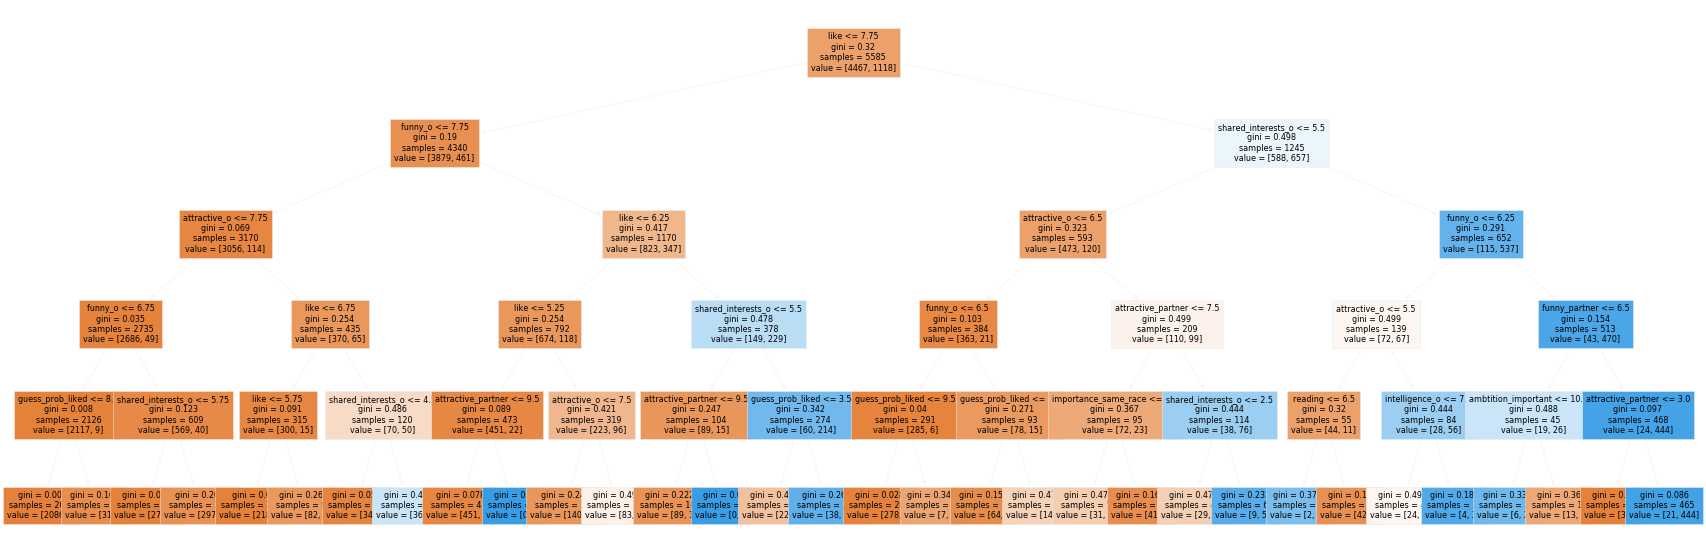

In [17]:
plt.figure(figsize=(30,10))
plot_tree(clfs[3], fontsize=8, filled=True, feature_names=numeric_conv_cols)

[Text(837.0, 498.3, 'like <= 7.75\ngini = 0.335\nsamples = 5585\nvalue = [4399, 1186]'),
 Text(418.5, 407.70000000000005, 'attractive_o <= 7.25\ngini = 0.199\nsamples = 4340\nvalue = [3855, 485]'),
 Text(209.25, 317.1, 'funny_partner <= 7.75\ngini = 0.099\nsamples = 3302\nvalue = [3129, 173]'),
 Text(104.625, 226.5, 'like <= 6.75\ngini = 0.054\nsamples = 2783\nvalue = [2705, 78]'),
 Text(52.3125, 135.89999999999998, 'like <= 5.5\ngini = 0.018\nsamples = 2172\nvalue = [2152, 20]'),
 Text(26.15625, 45.299999999999955, 'gini = 0.0\nsamples = 1429\nvalue = [1429, 0]'),
 Text(78.46875, 45.299999999999955, 'gini = 0.052\nsamples = 743\nvalue = [723, 20]'),
 Text(156.9375, 135.89999999999998, 'attractive_o <= 6.5\ngini = 0.172\nsamples = 611\nvalue = [553, 58]'),
 Text(130.78125, 45.299999999999955, 'gini = 0.072\nsamples = 456\nvalue = [439, 17]'),
 Text(183.09375, 45.299999999999955, 'gini = 0.389\nsamples = 155\nvalue = [114, 41]'),
 Text(313.875, 226.5, 'attractive_o <= 6.5\ngini = 0.299\

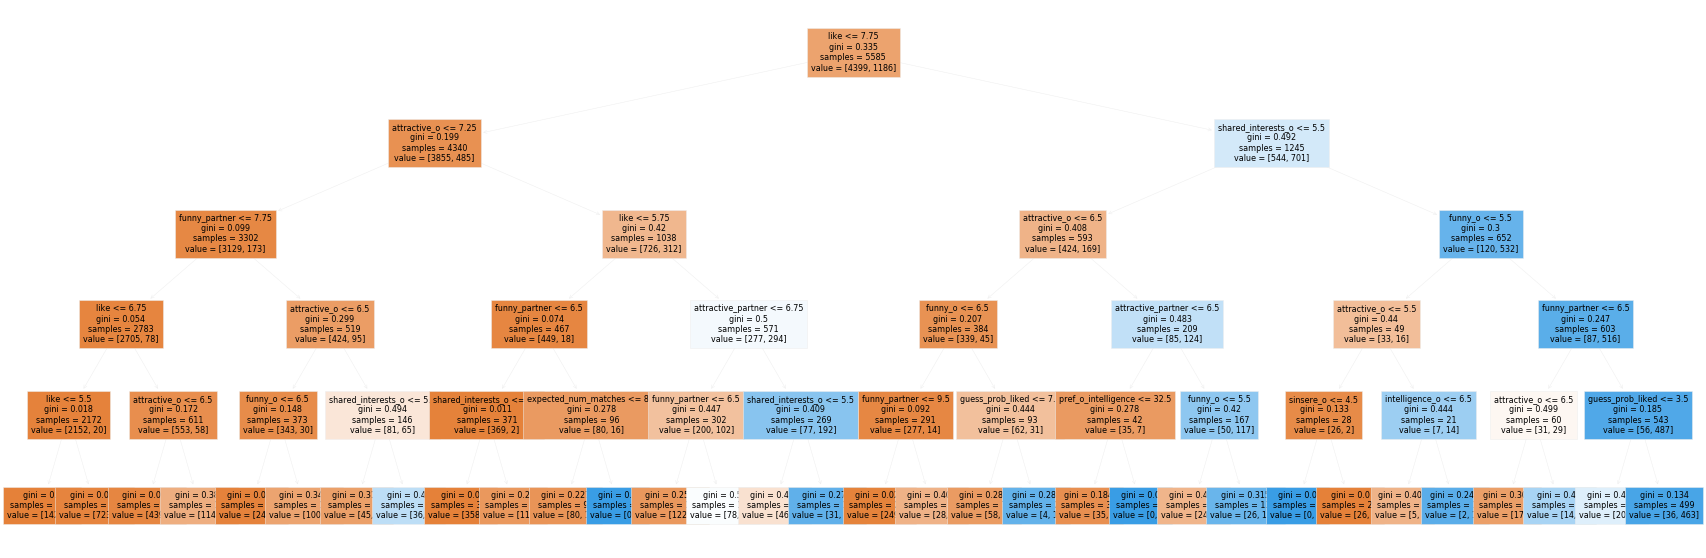

In [18]:
plt.figure(figsize=(30,10))
plot_tree(clfs[0], fontsize=8, filled=True, feature_names=numeric_conv_cols)